In [56]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)
directory = 'participant_data'

# Load board configuration from JSON.
board_config = {
    "scoring_left": 85,
    "scoring_top": 176,
    "scoring_width": 1341,
    "scoring_height": 150
}

scoring_left = board_config['scoring_left']
scoring_top = board_config['scoring_top']
scoring_width = board_config['scoring_width']
scoring_height = board_config['scoring_height']

In [37]:
cur_dir = os.getcwd()

In [38]:
dfs = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        if len(df) > 150:
            dfs.append(df)

# Merge all subject data while ensuring correct structure
df_all = pd.concat(dfs, ignore_index=True)


# Verify merged data
df_all["subject_id"].unique() 

array(['AE', 'AE_bonus'], dtype=object)

In [39]:
df_all

,x,y,feedback_block,subject_id
0,363.161220,378.904022,1,AE
1,494.888421,514.955031,1,AE
2,321.288062,220.938267,1,AE
3,362.047495,354.952245,1,AE
4,401.885483,306.923196,1,AE
...,...,...,...,...
380,301.435697,213.958523,15,AE_bonus
381,228.971053,520.267039,15,AE_bonus
382,273.370764,159.986196,15,AE_bonus
383,436.956787,369.938267,15,AE_bonus


In [40]:
feedback_blocks_series = df_all['feedback_block']
'''
feedback_blocks = {
    'trajectory': [4, 5, 6],
    'endpos': [7, 8, 9],
    'rl': [10, 11, 12],
    "no feedback": [1, 2, 3]  # Normal feedback type
}
'''

feedback_blocks = {
    'trajectory': [4, 5, 6],
    'endpos': [7, 8, 9],
    'rl': [10, 11, 12],
    'endpos_approx': [13, 14, 15],
    None: [1, 2, 3]  # Normal feedback type
}

feedback_types = pd.unique(feedback_blocks_series)


feedback_mapping = {}
for feedback_type, block_numbers in feedback_blocks.items():
    for block in block_numbers:
        feedback_mapping[block] = feedback_type        

feedback_mapping

{4: 'trajectory',
 5: 'trajectory',
 6: 'trajectory',
 7: 'endpos',
 8: 'endpos',
 9: 'endpos',
 10: 'rl',
 11: 'rl',
 12: 'rl',
 13: 'endpos_approx',
 14: 'endpos_approx',
 15: 'endpos_approx',
 1: None,
 2: None,
 3: None}

In [41]:
# Apply the feedback mapping to the DataFrame
df_all['feedback_type'] = df_all['feedback_block'].map(feedback_mapping)
df_all

,x,y,feedback_block,subject_id,feedback_type
0,363.161220,378.904022,1,AE,None
1,494.888421,514.955031,1,AE,None
2,321.288062,220.938267,1,AE,None
3,362.047495,354.952245,1,AE,None
4,401.885483,306.923196,1,AE,None
...,...,...,...,...,...
380,301.435697,213.958523,15,AE_bonus,endpos_approx
381,228.971053,520.267039,15,AE_bonus,endpos_approx
382,273.370764,159.986196,15,AE_bonus,endpos_approx
383,436.956787,369.938267,15,AE_bonus,endpos_approx


In [46]:
import matplotlib.path as mpath
import matplotlib.patches as patches
import numpy as np

# Define the vertices (same as you used for patches)
green_vertices = np.array([
    [85, 176],
    [85, 326],
    [1426, 176]
])
red_vertices = np.array([
    [1426, 326],
    [1426, 176],
    [85, 326]
])

# Create Path objects
green_path = mpath.Path(green_vertices)
red_path   = mpath.Path(red_vertices)

points = df_all[['x', 'y']].to_numpy()

df_all['hit'] = green_path.contains_points(points)
df_all['penalty']   = red_path.contains_points(points)

# record the block level with in each experiment.
df_all['block_level'] = df_all['feedback_block'].apply(lambda x: (x - 1) % 3 + 1)


In [63]:
# Filter the DataFrame to only block_level 1 or 3
df_unperturbed = df_all[df_all['block_level'].isin([1, 2, 3])]

# Group by feedback_type and block_level
grouped = df_unperturbed.groupby(['feedback_type', 'block_level'])

# Compute accuracy = fraction of hits
accuracy_series = grouped['hit'].mean().rename("accuracy")

# Convert it to a DataFrame for convenience
df_accuracy = accuracy_series.reset_index()
df_accuracy


,feedback_type,block_level,accuracy
0,endpos,1,0.150000
1,endpos,2,0.150000
2,endpos,3,0.100000
3,endpos_approx,1,0.300000
4,endpos_approx,2,0.033333
5,endpos_approx,3,0.100000
6,no feedback,1,0.150000
7,no feedback,2,0.250000
8,no feedback,3,0.000000
9,rl,1,0.200000


In [64]:
df_pivot = df_accuracy.pivot(
    index='feedback_type', 
    columns='block_level', 
    values='accuracy'
)
df_pivot.columns = [f"Block_{col}" for col in df_pivot.columns]  # rename columns
df_pivot = df_pivot.reindex([
    'no feedback', 
    'trajectory', 
    'endpos', 
    'rl', 
    'endpos_approx'
])  # reorder to match your feedback_block_order

# Inspect
print(df_pivot)

               Block_1   Block_2   Block_3
feedback_type                             
no feedback       0.15  0.250000  0.000000
trajectory        0.30  0.216667  0.250000
endpos            0.15  0.150000  0.100000
rl                0.20  0.200000  0.454545
endpos_approx     0.30  0.033333  0.100000


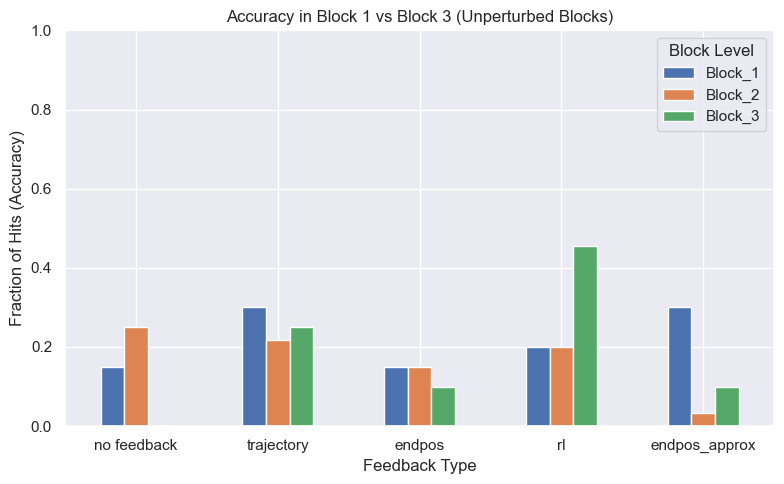

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

ax = df_pivot.plot(kind='bar', figsize=(8,5))

ax.set_title("Accuracy in Block 1 vs Block 3 (Unperturbed Blocks)")
ax.set_ylabel("Fraction of Hits (Accuracy)")
ax.set_xlabel("Feedback Type")
ax.set_ylim(0, 1.0)  # Assuming accuracy ranges between 0 and 1

# Display the legend (columns are Block_1, Block_3)
ax.legend(title="Block Level")

# Optional: rotate x-labels for readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.abspath(f'{cur_dir}/plots/block_accuracy.png'))
plt.show()

In [42]:
feedback_colors = {
    'trajectory': 'blue',
    'endpos': 'red',
    'rl': 'green',
    "no feedback": 'black',
    "endpos_approx": 'pink'
}

block_mapping = {
    1: "Block 1 (unperturbed)",
    2: "Block 2 (perturbed)",
    3: "Block 3 (unperturbed)"
}

# Define colors (matching the reference image)
dark_green = np.array([0, 100, 0]) / 255.0
light_green = np.array([144, 238, 144]) / 255.0
dark_red = np.array([139, 0, 0]) / 255.0
light_red = np.array([255, 182, 193]) / 255.0


In [43]:
def generate_gradient_image(scoring_rect, start_color, end_color):
    """Generate a gradient effect over a rectangular region with full RGB interpolation."""
    width, height = scoring_rect["scoring_width"], scoring_rect["scoring_height"]

    # Normalize colors to the range [0,1]
    start_color = np.array(start_color) / 255.0
    end_color = np.array(end_color) / 255.0

    # Create linear interpolation for all three RGB channels
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # Interpolate between start_color and end_color for each channel
    gradient_image = np.zeros((height, width, 3))
    for i in range(3):  # Loop over RGB channels
        gradient_image[:, :, i] = np.outer(np.ones(height), np.linspace(start_color[i], end_color[i], width))

    return gradient_image


INFO:root:Feedback Types: ['no feedback' 'trajectory' 'endpos' 'rl' 'endpos_approx']


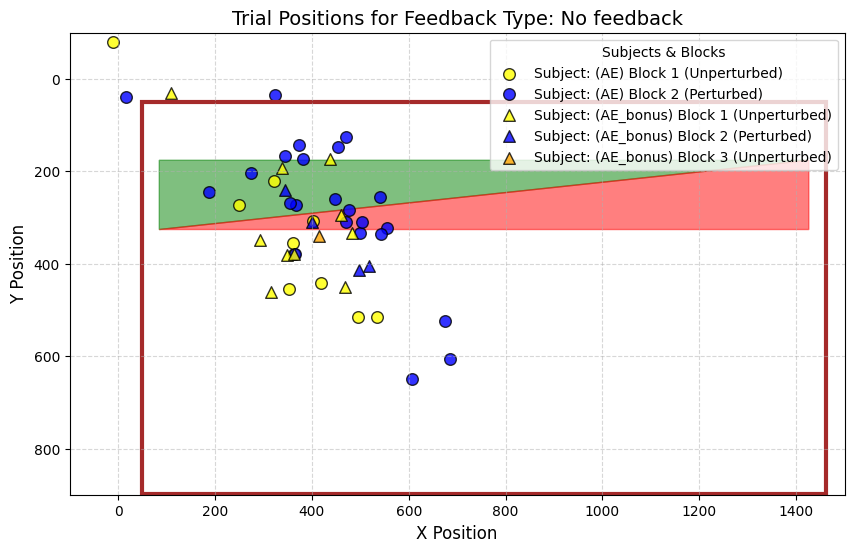

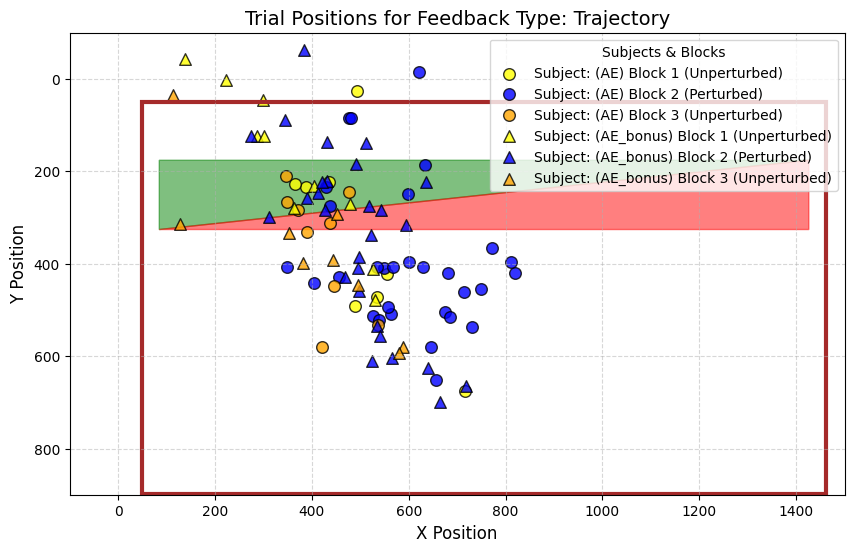

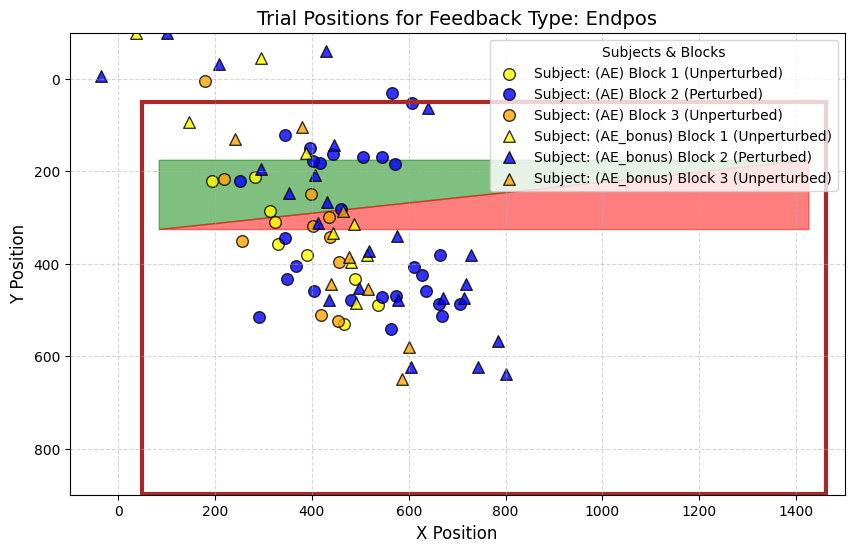

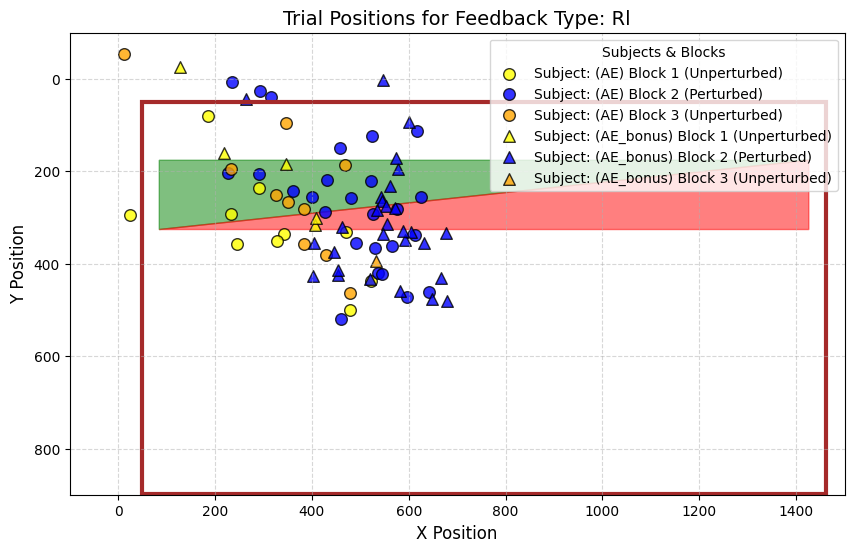

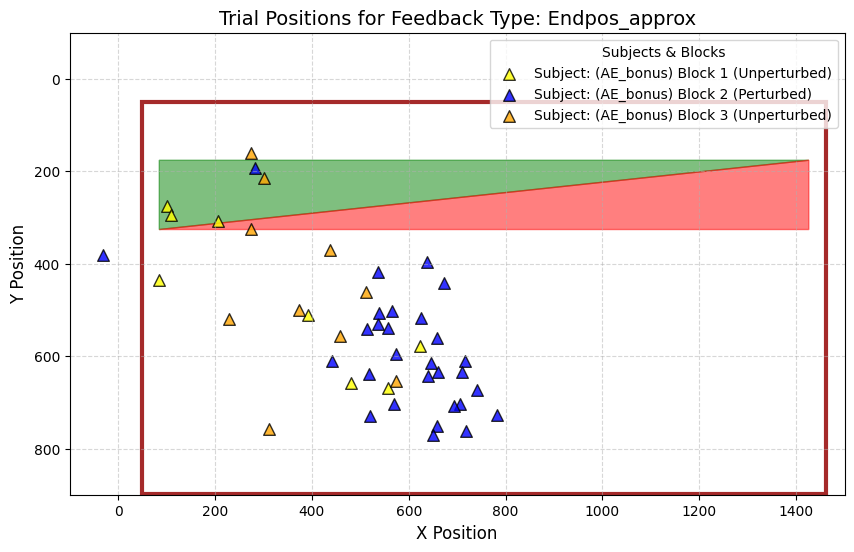

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# Define feedback block mappings
feedback_blocks = {
    'no feedback': [1, 2, 3],  # Normal feedback type
    'trajectory': [4, 5, 6],
    'endpos': [7, 8, 9],
    'rl': [10, 11, 12],
    'endpos_approx': [13, 14, 15],
}
feedback_block_order = ['no feedback', 'trajectory', 'endpos', 'rl', 'endpos_approx']
# Define block labels for the legend
block_mapping = {
    1: "Block 1 (Unperturbed)",
    2: "Block 2 (Perturbed)",
    3: "Block 3 (Unperturbed)"
}

# Define colors for feedback types
feedback_colors = {
    'trajectory': 'blue',
    'endpos': 'red',
    'rl': 'green',
    'no feedback': 'black'
}

# Define block colors
block_colors = {1: 'yellow', 2: 'blue', 3: 'orange'}

# Load dataset
df_all = pd.concat(dfs, ignore_index=True)  # Merge all subjects' data

# Apply the feedback mapping
df_all['feedback_type'] = df_all['feedback_block'].map({
    block: feedback for feedback, blocks in feedback_blocks.items() for block in blocks
})


# possible marker styles
marker_list = ['o', '^', 's', 'D', 'v', 'P']  # circles, triangles, squares, diamonds, inverted triangles, plus, etc.

# unique subject IDs
unique_subjects = df_all['subject_id'].unique()

# mapping: subject_id -> marker style

subject_marker_map = {}
for i, subj in enumerate(unique_subjects):
    subject_marker_map[subj] = marker_list[i % len(marker_list)]

logging.info(f"Feedback Types: {df_all['feedback_type'].unique()}")
# Generate separate plots for each feedback type
for fb_type in feedback_block_order:#feedback_blocks.keys():
    plt.figure(figsize=(10, 6))

    # Filter trials for the current feedback typy
    trials = df_all[df_all['feedback_type'] == fb_type].copy()
    if trials.empty:
        continue  # Skip if no data for this feedback type

    # Map feedback blocks into block levels (1, 2, 3)**
    trials['block_level'] = trials['feedback_block'].apply(lambda x: (x - 1) % 3 + 1)

    # Group by subject and block level**
    grouped_feedback_block = trials.groupby(['subject_id', 'block_level'])

    # Fix Reversed Green & Red Zones**
    green_polygon = patches.Polygon(
        [[85, 176], [85, 326], [1426, 176]], color="green", alpha=0.5  # Red is now on the LEFT
    )
    red_polygon = patches.Polygon(
        [[1426, 326], [1426, 176], [85, 326]], color="red", alpha=0.5  # Green is now on the RIGHT
    )

    plt.gca().add_patch(green_polygon)
    plt.gca().add_patch(red_polygon)

    # Plot each group (each subject & block level)**
    for (subject_id, block_level), group in grouped_feedback_block:
        plt.scatter(group['x'], group['y'],
                    label=f"Subject: ({subject_id}) {block_mapping[block_level]}",
                    color=block_colors[block_level], 
                    marker=subject_marker_map[subject_id],    
                    alpha=0.8, edgecolors='black', s=70)  # Increase size & edge contrast

    # Use JSON's Table Rectangle to Draw the Exact Border
    plt.gca().add_patch(plt.Rectangle(
        (50, 49), 1412, 850,  # Exact values from JSON
        fill=False, edgecolor='brown', linewidth=3
    ))

    # Improve Labels & Titles
    plt.xlabel("X Position", fontsize=12)
    plt.ylabel("Y Position", fontsize=12)
    plt.title(f"Trial Positions for Feedback Type: {fb_type.capitalize()}", fontsize=14)

    # Legend Improvements
    plt.legend(title="Subjects & Blocks", loc="upper right", fontsize=10, frameon=True)

    # Fix Y-Axis Limits (Inverted)**
    plt.ylim(900, -100)  # Match original Pygame coordinate system
    plt.xlim(-100, 1500)
    plt.grid(True, linestyle="--", alpha=0.5) 

    #Show the final plot
    plt.savefig(os.path.abspath(f"{cur_dir}/plots/feedback_{fb_type}.png"))

    plt.show()
